# Convolutional Layers

## Preparations

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import image

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 10,
})


np.set_printoptions(precision=5, suppress=True)


## Single Image Convolution

A convolution is done by multiplying a pixel’s and its neighboring pixels color value by a matrix (kernel matrix).

Here, we implement a convolution function for a single image. The implemenation is as follows, where:
* `img_in` is the image as a 2D matrix
* `kernel` is the filter kernel matrix
* `S` is the stride number

In [2]:
def convolve(img_in, kernel, S):
    F, _ = kernel.shape
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (F - S), S)
    C = np.arange(0, nc - (F - S), S)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.sum(kernel * img_in[r:r+F, c:c+F])

    return img_out

Typically, when `s = 1`, the dimension should not change. This is possible if the image has been previously padded. For a `3 x 3` filter matrix, we need 1 layer of padding. For a `5 x 5` filter matrix, we will need two layes of padding. However, if the filter dimensions are even numbers, we will not be able to apply uniform padding. Check [this material](https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html) for more infomation.

## Single Image Pooling

Pooling is a downsampling technique used in convolutional neural networks (CNNs) to reduce spatial dimensions of feature maps while preserving important features. It achieves this by selecting the maximum/mean value within each small, overlapping region (or "window") of the feature map. 

In [3]:
def maxpool(img_in, F, S):
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (F - S), S)
    C = np.arange(0, nc - (F - S), S)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.max(img_in[r:r+F, c:c+F])

    return img_out

In [4]:
def meanpool(img_in, F, S):
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (F - S), S)
    C = np.arange(0, nc - (F - S), S)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.mean(img_in[r:r+F, c:c+F])

    return img_out

## Single Image Normalization

This is a simple min-max normalization. This process causes the pixel values to range from 0 to 1.

In [5]:
def normalize(img_in):
    min_val = np.min(img_in)
    max_val = np.max(img_in)
    return (img_in - min_val) / (max_val - min_val)

## Batch Convolution

* `I`: number of the input images, the dimensions of all images are  `W x H`
* `O`: number of output images
* `I x O`: number of the convolution filters (kernels)
* `F x F`: dimension of the kernels 
* `S`: stride length
* `P`: number of padding layers
* The dimension of the output images are `W2 x H2`, where: `W2 = (W - F + 2 * P) / S + 1)` and `H2 = (H - F + 2 * P) / S + 1)`

In [6]:
def batch_convolve(input3d, filter4d, bias1d, P, S=1):
    # Volumetric matrix is addressed by using 3 indices: [first index, second index, third index]
    # Depth is represented first index
    H, W, I = input3d.shape;
    F, _, _, O = filter4d.shape;
    
    # Do ZERO padding
    input3d = np.pad(input3d, ((P, P), (P, P), (0, 0)), 'constant', constant_values=((0, 0), (0, 0),(0, 0)))

    W2 = np.int32((W - F + 2 * P) / S + 1)
    H2 = np.int32((H - F + 2 * P) / S + 1)
    O = np.int32(O)  
    I = np.int32(I)

    output3d = np.zeros((W2, H2, O), dtype=np.float32)

    for o in range(O):
        output3d[:, :, o] = output3d[:, :, o] + bias1d[o]
        for i in range(I):
            input = input3d[:, :, i]
            output3d[:, :, o] = output3d[:, :, o] + convolve(input, kernel=filter4d[:, :, i, o], S=S)

    return output3d

## Batch Pooling

Batch pooling involves:
* `D` images with a dimension of `W x H`
* a pooling filter of `F x F` 
* a stride length of `S`

In [7]:
def batch_maxpool(input3d, F, S):
    H, W, D = input3d.shape;

    W2 = np.int32((W - F) / S + 1)
    H2 = np.int32((H - F) / S + 1)
    D2 = np.int32(D)

    output3d = np.zeros((W2, H2, D2), dtype=np.float32)

    for d2 in range(D2):
        input = input3d[:, :, d2]
        output3d[:, :, d2] = maxpool(input, F, S)

    return output3d

In [8]:
def batch_meanpool(input3d, F, S):
    H, W, D = input3d.shape;

    W2 = np.int32((W - F) / S + 1)
    H2 = np.int32((H - F) / S + 1)
    D2 = np.int32(D)

    output3d = np.zeros((W2, H2, D2), dtype=np.float32)

    for d2 in range(D2):
        input = input3d[:, :, d2]
        output3d[:, :, d2] = meanpool(input, F, S)

    return output3d

## Batch Normalization

In [9]:
def batch_normalization(input3d):
    H, W, D = input3d.shape;
    output3d = np.zeros((W, H, D), dtype=np.float32)

    for d in range(D):
        output3d[:, :, d] = normalize(input3d[:, :, d])

    return output3d

## Activations

![](./images/activations.png)

In [10]:
def ReLU(input3d):
    return (np.maximum(0, input3d))

def LeakyReLU(input3d):
    return (np.maximum(0.1*input3d, input3d))

----

## Demonstrations

### 1. Batch Convolution of an Image

For the demonstration, we will load a colored image (3 channels). 

image dimension: (512, 512, 3)


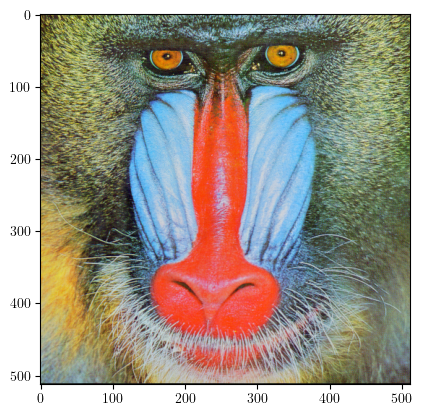

In [11]:
%matplotlib inline

baboon = np.int32(image.imread('./images/baboon.png') * 255.0)
print("image dimension:", baboon.shape)

plt.imshow(baboon)
plt.show()

For the sake of clarity, let us plot the loaded image as three different grayscale images

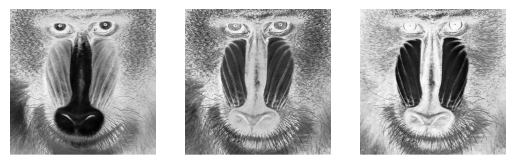

In [12]:
%matplotlib inline
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(baboon[:, :, i], cmap='Greys')
    plt.axis('off')

Let's apply `(3 x 3 x 3 x 2)` arbitrary filters:
* filter kernel dimesion: `3 x 3`
* number of inputs: `3`
* number of outputs: `2`

In [13]:
F = np.zeros((3, 3, 3, 2))

F[:,:, 0, 0] = np.array([[0.0625, 0.125, 0.0625],
                         [0.125, 0.25, 0.125],
                         [0.0625, 0.125, 0.0625]])

F[:,:, 0, 1] = np.array([[-2, -1,  0],
                         [-1,  1,  1],
                         [ 0,  1,  2]])

F[:,:, 1, 0] = np.array([[-1, -1, -1],
                         [-1, 8, -1],
                         [-1, -1, -1]])

F[:,:, 1, 1] = np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]])

F[:,:, 2, 0] = np.array([[-1, -1, -1],
                         [-1, 8, -1],
                         [-1, -1, -1]])

F[:,:, 2, 1] = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])


bias = np.zeros(2)

In [14]:
output = batch_convolve(baboon, F, bias, 1)
output = batch_meanpool(output, 2, 2)
output = batch_normalization(output)
output = ReLU(output)

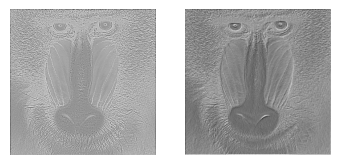

In [15]:
for i in range(output.shape[2]):
    plt.subplot(1, 3, i+1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(output[:,:, i]*255, cmap='Greys')
    plt.axis('off')

-----------------------

### 2. LeNet-1

The following picture is the LeNet-1 layer architecture diagram.

![](./images/lenet-1.png)

First, we load the USPS datasets. There are two sets of data: training data and testing data.

In [16]:
import h5py
with h5py.File("./datasets/usps/usps.h5", 'r') as hf:
    x_train = hf.get("train").get('data')[:].reshape(-1, 16, 16) * 255.0
    y_train = np.int32(hf.get("train").get('target')[:]) 

    x_test = hf.get("test").get('data')[:].reshape(-1, 16, 16) * 255.0
    y_test = np.int32(hf.get("test").get('target')[:]) 

print("Training data:")
print("Dimension numbers :", x_train.shape[1] * x_train.shape[2])
print("Number of data    :", x_train.shape[0])

print("\nTesting data:")
print("Dimension numbers :", x_test.shape[1] * x_test.shape[2])
print("Number of data    :", x_test.shape[0])


Training data:
Dimension numbers : 256
Number of data    : 7291

Testing data:
Dimension numbers : 256
Number of data    : 2007


In [17]:
# Peforming reshaping operation
x_train = x_train.reshape(x_train.shape[0], 16, 16, 1)
x_test = x_test.reshape(x_test.shape[0], 16, 16, 1)

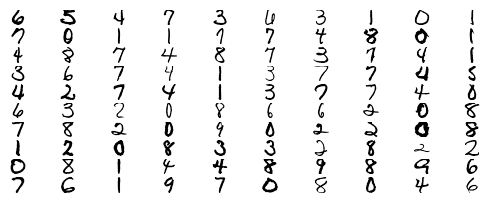

In [18]:
for i in range(100):
    X = x_train[i,:,:]
    plt.subplot(20, 10, i + 1)
    plt.imshow(X.astype('uint8'), cmap='Greys')
    plt.axis('off')

Next, we also load all weight matrices and bias vectors from the previously trained network as found in [lenet1.ipynb](./lenet1.ipynb).

In [19]:
def read_weight(fn, I=None, J=None, K=None, L=None):
    file = open(fn, 'r')

    # 4D
    if I is not None and J is not None and K is not None and L is not None:
        w  = np.zeros((I, J, K, L))
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    for l in range(L):
                        val = np.float32(file.readline())
                        w[i, j, k, l] = val
        return w

    # 2D
    elif I is not None and J is not None:
        w  = np.zeros((I, J))
        for i in range(I):
            for j in range(J):
                val = np.float32(file.readline())
                w[i, j] = val
        return w
    
    # 1D
    elif I is not None: 
        w  = np.zeros(I)
        for i in range(I):
            val = np.float32(file.readline())
            w[i] = val
        return w

    else:
        return 0

In [20]:
w1  = np.load('./datasets/usps/weight-1.npy')  # weight
w2  = np.load('./datasets/usps/weight-2.npy')  # bias
w3  = np.load('./datasets/usps/weight-3.npy')  # weight
w4  = np.load('./datasets/usps/weight-4.npy')  # bias
w5  = np.load('./datasets/usps/weight-5.npy')  # weight
w6  = np.load('./datasets/usps/weight-6.npy')  # bias
w7  = np.load('./datasets/usps/weight-7.npy')  # weight
w8  = np.load('./datasets/usps/weight-8.npy')  # bias


We then tranlsate the layer architecture diagram into actual codes.

The sequential order of the CNN is as follows: 

`input --> C1 --> reLU --> M1 --> C2 --> ReLU --> M2 --> FCN`

where C and M are convolutional and max-pooling layers, respectively. FCN is a fully-connected network layer.

In [21]:
y_predict = []
for k in range(x_test.shape[0]):
    # C1
    output1 = batch_convolve(x_test[k].reshape(16, 16, 1), w1, w2, 2)
    output2 = ReLU(output1)
    # M1
    output3 = batch_maxpool(output2, 2, 2)
    # C2
    output4 = batch_convolve(output3, w3, w4, 2)
    output5 = ReLU(output4)
    # M2
    output6 = batch_maxpool(output5, 2, 2)

    # FCN
    output7 = output6.flatten()
    output7 = output7.reshape(1, 192)
    y3 = output7 @ w5 + w6
    y4 = np.maximum(0, y3)
    y5 = y4 @ w7 + w8
    y_predict.append(np.argmax(y5))

y_predict = np.array(y_predict)


Do predictions by using the loaded weights and check the accuracy.

In [22]:
# Predict on the validation set
test_acc = (y_predict == y_test).mean()
print('Testing accuracy : ', test_acc)

Testing accuracy :  0.9491778774289985


How to do predict single data?

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

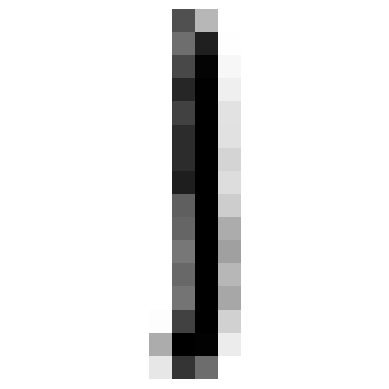

In [23]:
X = x_train[7,:,:]
plt.imshow(X.astype('uint8'), cmap='Greys')
plt.axis('off')

In [24]:
output1 = batch_convolve(x_train[7].reshape(16, 16, 1), w1, w2, 2)
output2 = ReLU(output1)
output3 = batch_maxpool(output2, 2, 2)
output4 = batch_convolve(output3, w3, w4, 2)
output5 = ReLU(output4)
output6 = batch_maxpool(output5, 2, 2)
output7 = output6.flatten()
output7 = output7.reshape(1, 192)
output8 = output7 @ w5 + w6
output8 = np.maximum(0, output8)
output9 = output8 @ w7 + w8

In [25]:
output9

array([[ -9.42495,  18.61139, -17.61025, -12.7756 ,   6.73645,  -7.3124 ,
         -7.9837 , -10.35735,  -0.82   ,  -2.60501]], dtype=float32)

In [28]:
np.argmax(output9)

np.int64(1)